# 1. Introduction

## Objective
The players.csv dataset provides comprehensive data about football players. Our aim is to explore this dataset to uncover insights into the demographics, skills, and market values of these players. We will seek answers to questions such as:

* What is the distribution of players by age, nationality, and position?
* How do market values vary across different player characteristics?

## Dataset Overview
The dataset comprises information on 30,302 football players, covering aspects like name, nationality, position, market value, and more. It offers a rich source for understanding trends and patterns in the world of football.


# 2. Data Loading and Preliminary Analysis
Let's load the data and take a preliminary look at its structure and content.

In [55]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
players_df = pd.read_csv('../data/players.csv')

# Display the first few rows of the dataframe
players_df.head()

,player_id,first_name,last_name,name,last_season,current_club_id,player_code,country_of_birth,city_of_birth,country_of_citizenship,...,foot,height_in_cm,market_value_in_eur,highest_market_value_in_eur,contract_expiration_date,agent_name,image_url,url,current_club_domestic_competition_id,current_club_name
0,598,Timo,Hildebrand,Timo Hildebrand,2014,24,timo-hildebrand,Germany,Worms,Germany,...,NaN,NaN,NaN,10000000.0,NaN,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/timo-hildebran...,L1,Eintracht Frankfurt
1,670,Martin,Petrov,Martin Petrov,2012,714,martin-petrov,Bulgaria,Vratsa,Bulgaria,...,NaN,NaN,NaN,12000000.0,NaN,IFM,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/martin-petrov/...,ES1,RCD Espanyol Barcelona
2,1323,Martin,Amedick,Martin Amedick,2012,24,martin-amedick,Germany,Paderborn,Germany,...,NaN,NaN,NaN,2750000.0,NaN,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/martin-amedick...,L1,Eintracht Frankfurt
3,3195,Jermaine,Pennant,Jermaine Pennant,2013,512,jermaine-pennant,England,Nottingham,England,...,right,173.0,NaN,10500000.0,NaN,Andrew Sky,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/jermaine-penna...,GB1,Stoke City
4,3259,Damien,Duff,Damien Duff,2013,931,damien-duff,Ireland,Ballyboden,Ireland,...,left,177.0,NaN,17000000.0,NaN,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/damien-duff/pr...,GB1,Fulham FC


The initial view of the `players.csv` dataset reveals several key aspects and potential areas of interest:

1. **Player Identification and Names**:
    * Columns like `player_id`, `first_name`, `last_name`, and `name` provide basic identification details for each player. 
    
    * These columns can be used to uniquely identify players and understand the dataset's diversity in terms of player representation.


2. **Personal and Demographic Information**:
   * The dataset includes personal information such as `country_of_birth`, `city_of_birth`, and `country_of_citizenship`. This can be valuable for analyzing the geographical distribution and diversity of players.
   
   * Columns like `height_in_cm` and foot (which has missing values in some cases) offer insights into the physical attributes of players.

3. **Professional Details**:
    * Information about players' professional career is captured in columns like `last_season`, `current_club_id`, `current_club_name`, and `position`. This allows for an analysis of players' career trajectories and current affiliations.

    * `sub_position` provides a more detailed view of the player's role within the team.

4. **Market Value and Contracts**:
    * The dataset contains financial aspects such as `market_value_in_eur`, `highest_market_value_in_eur`, and `contract_expiration_date`. *However, many of these values are **missing**, indicating potential data quality issues. We'll be exploring the potential reasons behind this soon.* 

    * This data is crucial for analyzing the market dynamics and economic value of players.

5. **Representation and Public Image**:
    * Information on players' agents (`agent_name`) and their online presence (`image_url`, `url`) offers an angle to explore representation and popularity aspects.
    

6. **Data Quality Observations**:
    * There are noticeable missing values in several columns, especially `foot`, `height_in_cm`, `market_value_in_eur`, and `contract_expiration_date`.
    * For certain columns like `foot`, substituting missing values with "Unknown" could be a strategic choice for maintaining data integrity without losing the essence of the dataset.


Given these observations, the dataset presents numerous opportunities for in-depth analysis, ranging from demographic studies to financial evaluations. 


# 3. Data Cleaning and Preprocessing
As we delve deeper into the players.csv dataset, our goal is to ensure the data is clean, consistent, and ready for analysis. This involves addressing missing values, data types, and any other inconsistencies. We will also explore the dataset further to uncover additional insights and cleaning needs.

## Handling Missing Values
### Substituting Missing Values in `foot`
We noticed missing values in the `foot` column. It's quite important for our analysis to have this information, so we will substitute missing values with "Unknown". This approach maintains data integrity while providing a placeholder for unknown information, because the non-existance of a value is also informative in itself.

In [56]:
# First, let's see exactly which types of different values this column contains.
# We can use the .unique() method to do this.
players_df['foot'].unique()

array([nan, 'right', 'left', 'both'], dtype=object)

In [57]:
# Where the 'foot' columns value is neither 'Left', 'Right' or 'Both', replace it with 'Unknown'
# players_df['foot'] = players_df['foot'].replace(['left', 'right', 'both'], 'unknown')
# Seems prone to problems, especially due to case sensitivity. 
# Instead, there's a handy function called fillna() that we can use to replace all non-valid values in a column with a specified value.
players_df['foot'] = players_df['foot'].fillna('unknown')

players_df.head()

,player_id,first_name,last_name,name,last_season,current_club_id,player_code,country_of_birth,city_of_birth,country_of_citizenship,...,foot,height_in_cm,market_value_in_eur,highest_market_value_in_eur,contract_expiration_date,agent_name,image_url,url,current_club_domestic_competition_id,current_club_name
0,598,Timo,Hildebrand,Timo Hildebrand,2014,24,timo-hildebrand,Germany,Worms,Germany,...,unknown,NaN,NaN,10000000.0,NaN,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/timo-hildebran...,L1,Eintracht Frankfurt
1,670,Martin,Petrov,Martin Petrov,2012,714,martin-petrov,Bulgaria,Vratsa,Bulgaria,...,unknown,NaN,NaN,12000000.0,NaN,IFM,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/martin-petrov/...,ES1,RCD Espanyol Barcelona
2,1323,Martin,Amedick,Martin Amedick,2012,24,martin-amedick,Germany,Paderborn,Germany,...,unknown,NaN,NaN,2750000.0,NaN,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/martin-amedick...,L1,Eintracht Frankfurt
3,3195,Jermaine,Pennant,Jermaine Pennant,2013,512,jermaine-pennant,England,Nottingham,England,...,right,173.0,NaN,10500000.0,NaN,Andrew Sky,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/jermaine-penna...,GB1,Stoke City
4,3259,Damien,Duff,Damien Duff,2013,931,damien-duff,Ireland,Ballyboden,Ireland,...,left,177.0,NaN,17000000.0,NaN,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/damien-duff/pr...,GB1,Fulham FC


### Other Columns with Missing Data
We observed missing data in several columns like `market_value_in_eur`, `height_in_cm`, and `contract_expiration_date`. We will assess the proportion of missing data in these columns to decide on further action. If a significant portion of data is missing, we may choose to leave these columns as is for now, to avoid introducing biases with imputations.

In [58]:
missing_data_percentage = players_df.isnull().mean() * 100
missing_data_percentage

player_id                                0.000000
first_name                               6.484720
last_name                                0.000000
name                                     0.000000
last_season                              0.000000
current_club_id                          0.000000
player_code                              0.000000
country_of_birth                         8.874002
city_of_birth                            7.270147
country_of_citizenship                   1.791961
date_of_birth                            0.155105
sub_position                             0.567619
position                                 0.000000
foot                                     0.000000
height_in_cm                             6.923635
market_value_in_eur                     36.033925
highest_market_value_in_eur              4.359448
contract_expiration_date                37.842387
agent_name                              50.693024
image_url                                0.000000


The highest percentages of missing data are in `agent_name` (50.69%), `contract_expiration_date` (37.84%), and `market_value_in_eur` (36.03%). This indicates a substantial gap in the dataset regarding player representation and financial details.
The missing data in `market_value_in_eur` and `contract_expiration_date` could significantly impact analyses related to player valuations and contract statuses.

Columns like `first_name` (6.48%), `country_of_birth` (8.87%), `city_of_birth` (7.27%), and `height_in_cm` (6.92%) have moderate levels of missing data.
While these missing values are not as extensive, they still warrant attention, especially for analyses focusing on player demographics and physical attributes.

`sub_position` (0.57%) and `date_of_birth` (0.16%) have relatively low percentages of missing data, suggesting these fields are generally well-recorded.
The low missing data in `date_of_birth` is particularly important for age-related analysis

We will explore the **overall** implications and limitations of such data gaps at the end of this notebook, for now, let's talk about the next steps limitations.

## Strategic Imputations
For columns with significant missing data, such as `agent_name`, it may be reasonable to consider inserting a placeholder like "Unknown", as we did before. However, for financial columns like `market_value_in_eur`, imputing values could introduce bias, so it's critical to acknowledge that this limitation will unfortunately not allow us to peform that kind of analysis in this notebook.

### Data Type Conversions
For columns like `date_of_birth` and `contract_expiration_date`, despite having some missing values, converting them to datetime format will facilitate age and contract duration analyses. 

Converting the above columns to a datetime format will enable more efficient handling of age-related and contract duration analyses. Any NAT (or any invalid) fields will be ignored in future calculations, so we don't need to worry about the missing values in these columns.

In [60]:
# coerce will force any values that can't be converted to a date to be converted to a NaT value.
players_df['date_of_birth'] = pd.to_datetime(players_df['date_of_birth'], errors='coerce')
players_df['contract_expiration_date'] = pd.to_datetime(players_df['contract_expiration_date'], errors='coerce')

## Missing Data Patterns
In this phase we will focus on investigating if the missing data in significant columns follows any specific patterns related to countries, clubs, or other attributes. This will help us understand if there are any biases in the data, and if so, how to address (or ignore) them.

### by Country
We'll start by exploring if the missing data in key columns like `market_value_in_eur` is associated with specific countries.

In [61]:
missing_values_by_country = players_df[players_df['market_value_in_eur'].isnull()].groupby('country_of_citizenship').size()
total_players_by_country = players_df.groupby('country_of_citizenship').size()
percentage_missing_by_country = (missing_values_by_country / total_players_by_country * 100).sort_values(ascending=False)

### by Club
Similarly, we'll examine if the missing data is linked to specific clubs.

In [62]:
missing_values_by_club = players_df[players_df['market_value_in_eur'].isnull()].groupby('current_club_name').size()
total_players_by_club = players_df.groupby('current_club_name').size()
percentage_missing_by_club = (missing_values_by_club / total_players_by_club * 100).sort_values(ascending=False)

### Visualization 
Visualizing the distribution of missing data across countries and clubs can provide a clearer picture. Bar charts or heatmaps can be effective for this purpose.

If certain countries or clubs have a disproportionately high percentage of missing data, it could suggest a pattern or bias in data collection. This could be due to various factors, such as the prominence of the league, the visibility of the club, or regional data collection practices.

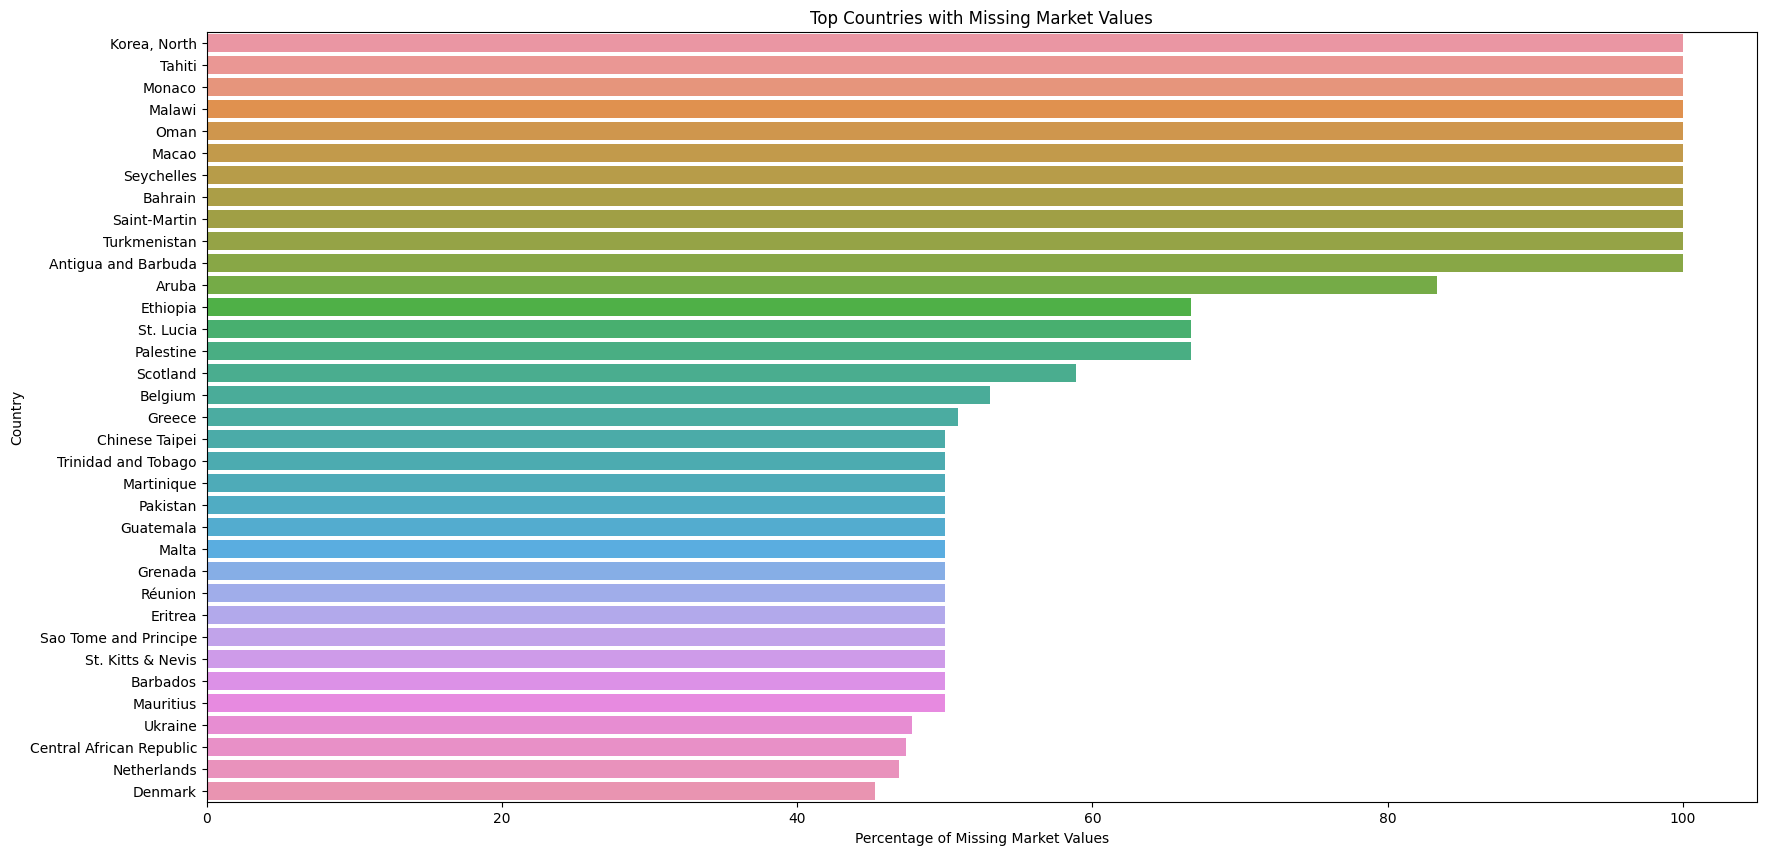

In [63]:
# Top countries with missing 'market_value_in_eur'
top_countries = percentage_missing_by_country.head(35)
plt.figure(figsize=(20, 10))
sns.barplot(x=top_countries, y=top_countries.index)
plt.title('Top Countries with Missing Market Values')
plt.xlabel('Percentage of Missing Market Values')
plt.ylabel('Country')
plt.show()

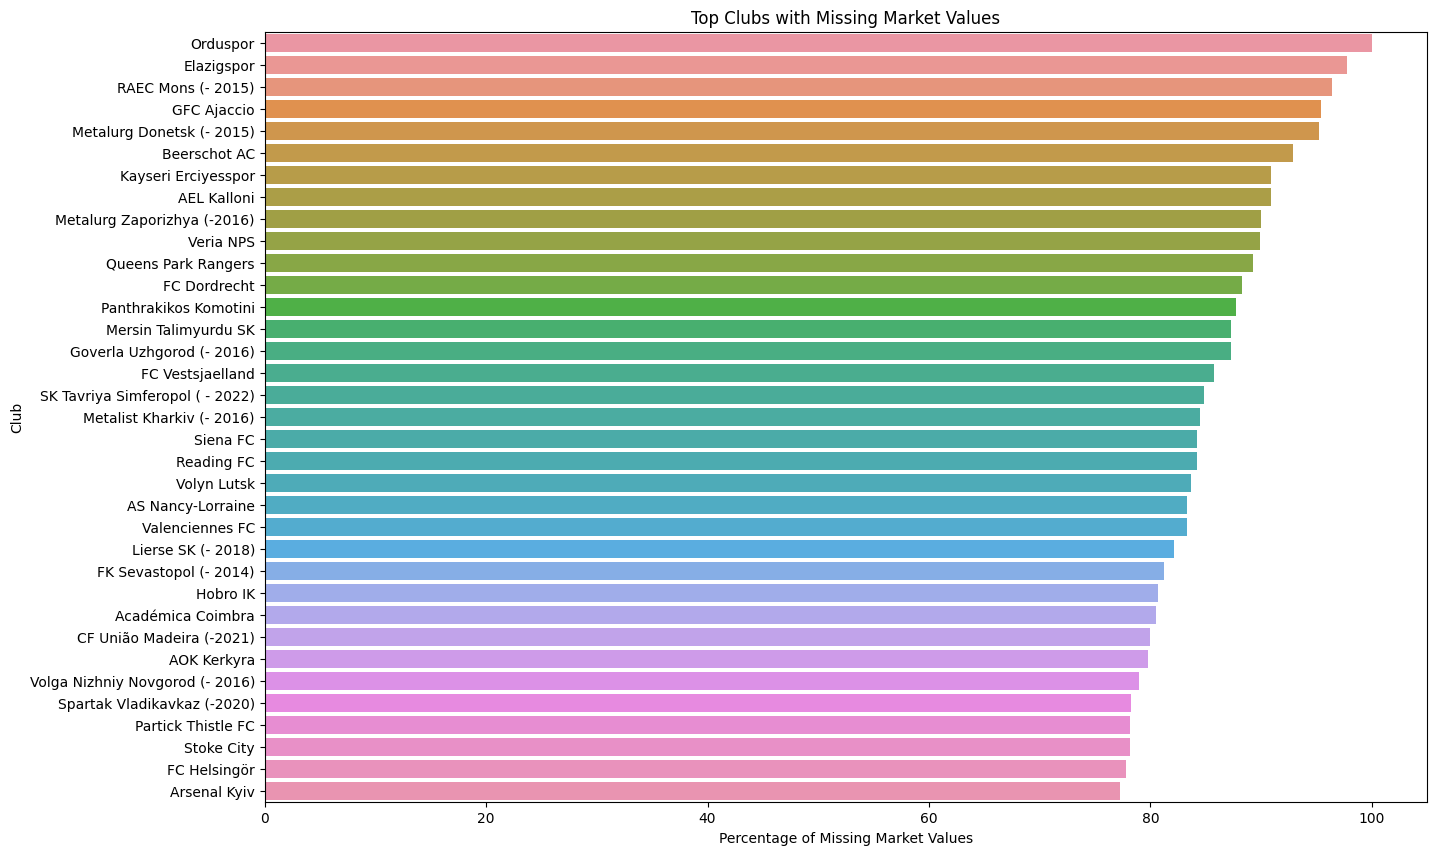

In [64]:
# Top clubs with missing 'market_value_in_eur'
top_clubs = percentage_missing_by_club.head(35)
plt.figure(figsize=(15, 10))
sns.barplot(x=top_clubs, y=top_clubs.index)
plt.title('Top Clubs with Missing Market Values')
plt.xlabel('Percentage of Missing Market Values')
plt.ylabel('Club')
plt.show()

###  `height_in_cm`, `contract_expiration_date`, and `agent_name` patterns
Again, for each column, we'll:

- Calculate the percentage of missing data by country and by club.
- Visualize the results to identify if the missing data is concentrated in specific areas.

### height_in_cm

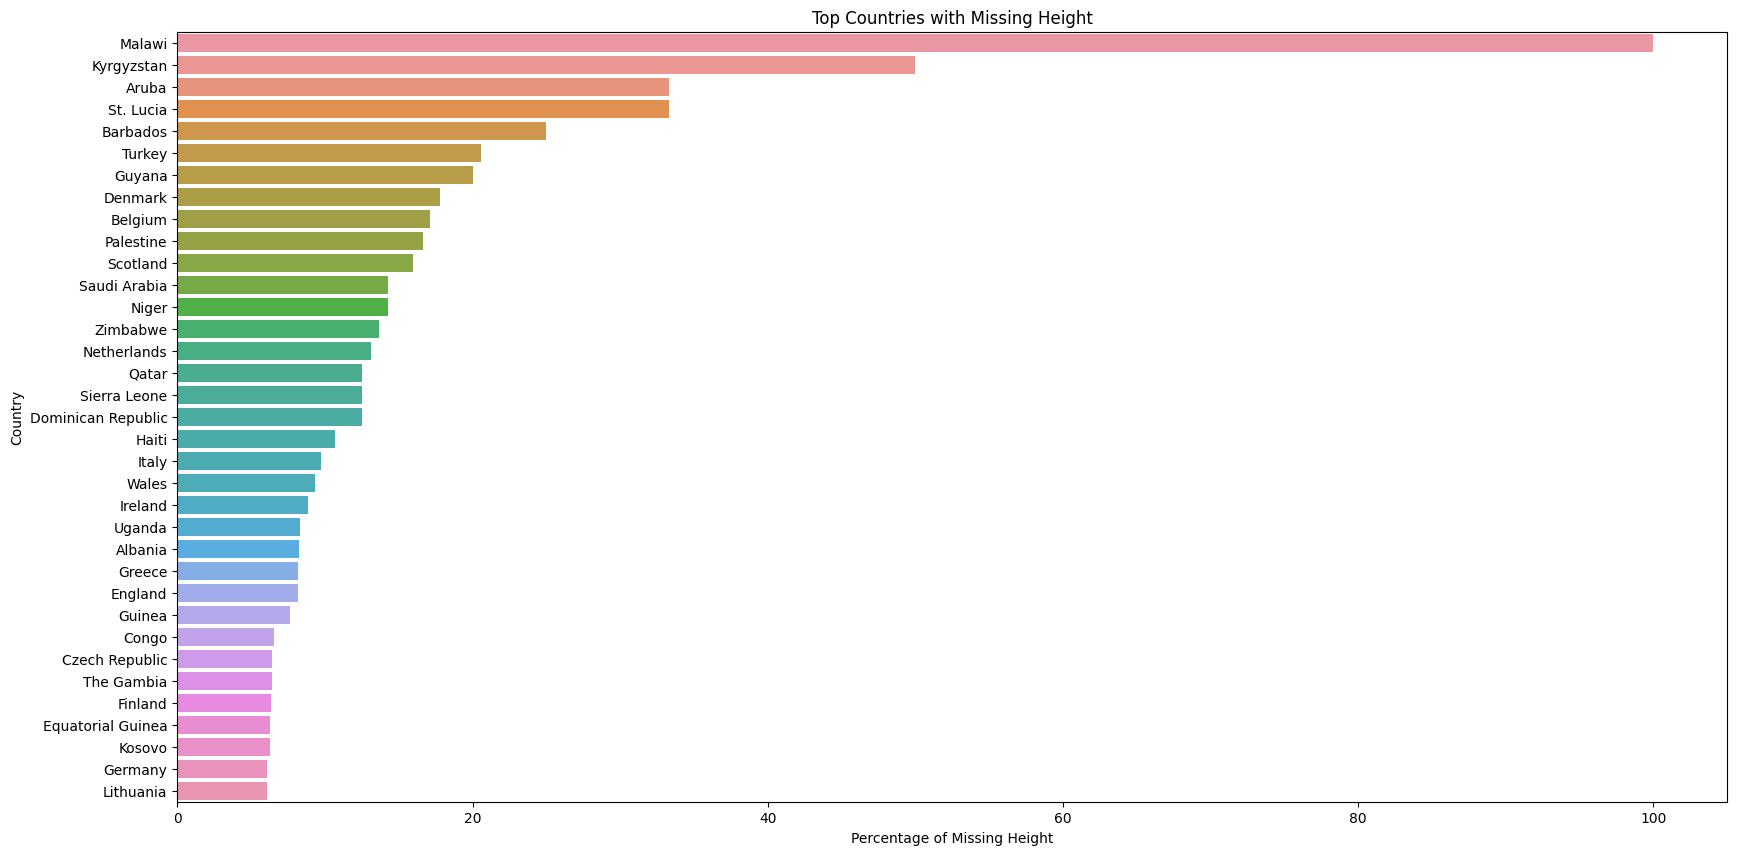

In [65]:
# Calculate the percentage of missing data by country
missing_by_country = players_df[players_df['height_in_cm'].isnull()].groupby('country_of_citizenship').size()
total_by_country = players_df.groupby('country_of_citizenship').size()
percentage_missing_by_country = (missing_by_country / total_by_country * 100).sort_values(ascending=False)

# Calculate the percentage of missing data by club
missing_by_club = players_df[players_df['height_in_cm'].isnull()].groupby('current_club_name').size()
total_by_club = players_df.groupby('current_club_name').size()
percentage_missing_by_club = (missing_by_club / total_by_club * 100).sort_values(ascending=False)

# Top countries with missing 'height_in_cm'
top_countries = percentage_missing_by_country.head(35)
plt.figure(figsize=(20, 10))
sns.barplot(x=top_countries, y=top_countries.index)
plt.title('Top Countries with Missing Height')
plt.xlabel('Percentage of Missing Height')
plt.ylabel('Country')
plt.show()

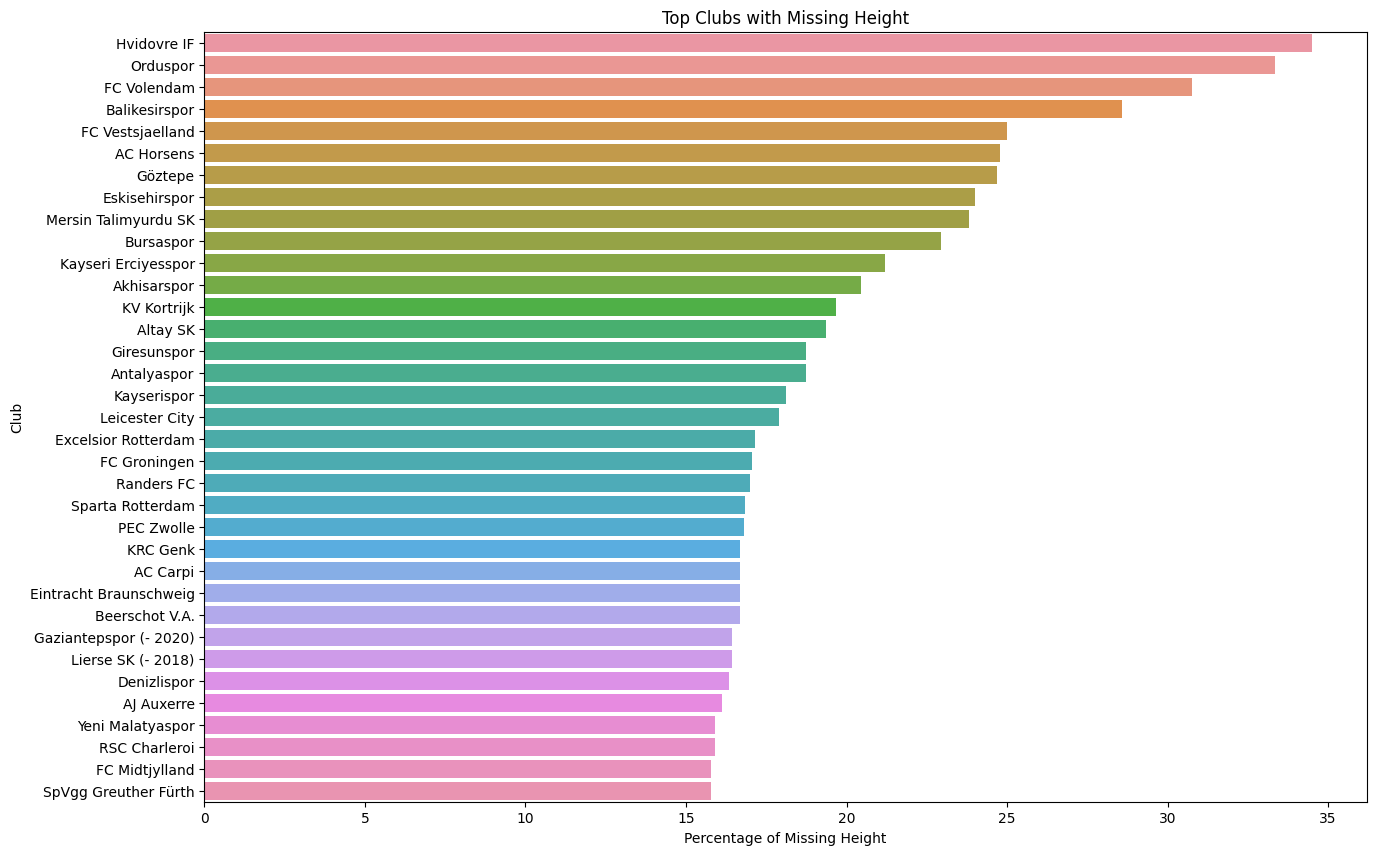

In [66]:
# Top clubs with missing 'height_in_cm'
top_clubs = percentage_missing_by_club.head(35)
plt.figure(figsize=(15, 10))
sns.barplot(x=top_clubs, y=top_clubs.index)
plt.title('Top Clubs with Missing Height')
plt.xlabel('Percentage of Missing Height')
plt.ylabel('Club')
plt.show()

### contract_expiration_date

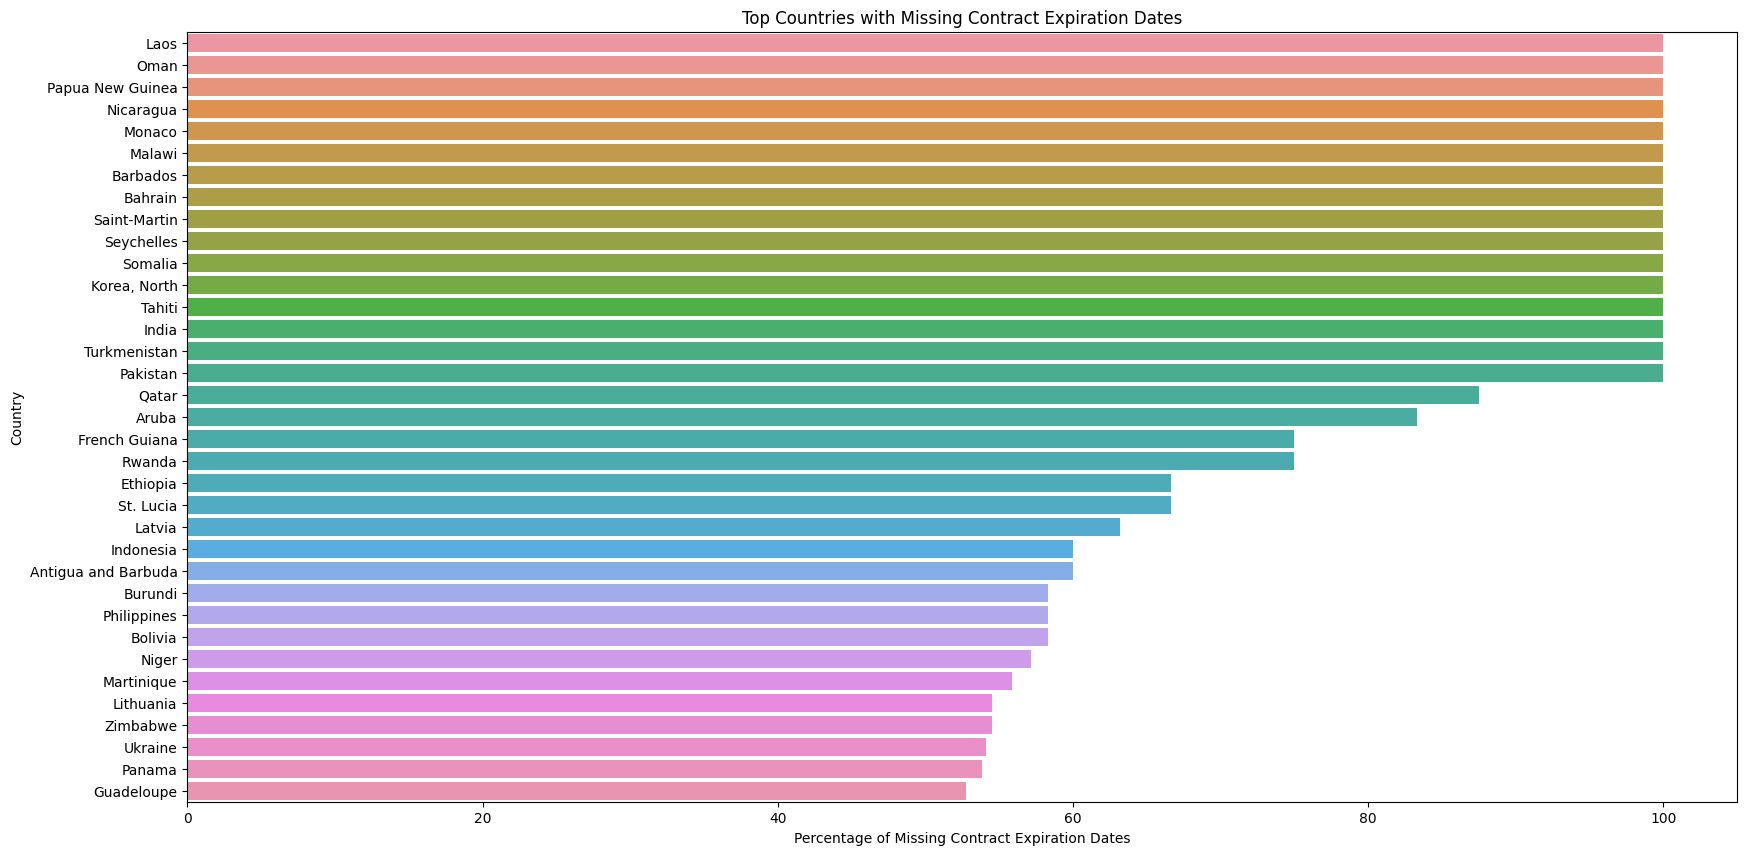

In [67]:
# Calculate the percentage of missing data by country
missing_by_country = players_df[players_df['contract_expiration_date'].isnull()].groupby('country_of_citizenship').size()
total_by_country = players_df.groupby('country_of_citizenship').size()
percentage_missing_by_country = (missing_by_country / total_by_country * 100).sort_values(ascending=False)

# Calculate the percentage of missing data by club
missing_by_club = players_df[players_df['contract_expiration_date'].isnull()].groupby('current_club_name').size()
total_by_club = players_df.groupby('current_club_name').size()
percentage_missing_by_club = (missing_by_club / total_by_club * 100).sort_values(ascending=False)

# Top countries with missing 'contract_expiration_date'
top_countries = percentage_missing_by_country.head(35)
plt.figure(figsize=(20, 10))
sns.barplot(x=top_countries, y=top_countries.index)
plt.title('Top Countries with Missing Contract Expiration Dates')
plt.xlabel('Percentage of Missing Contract Expiration Dates')
plt.ylabel('Country')
plt.show()

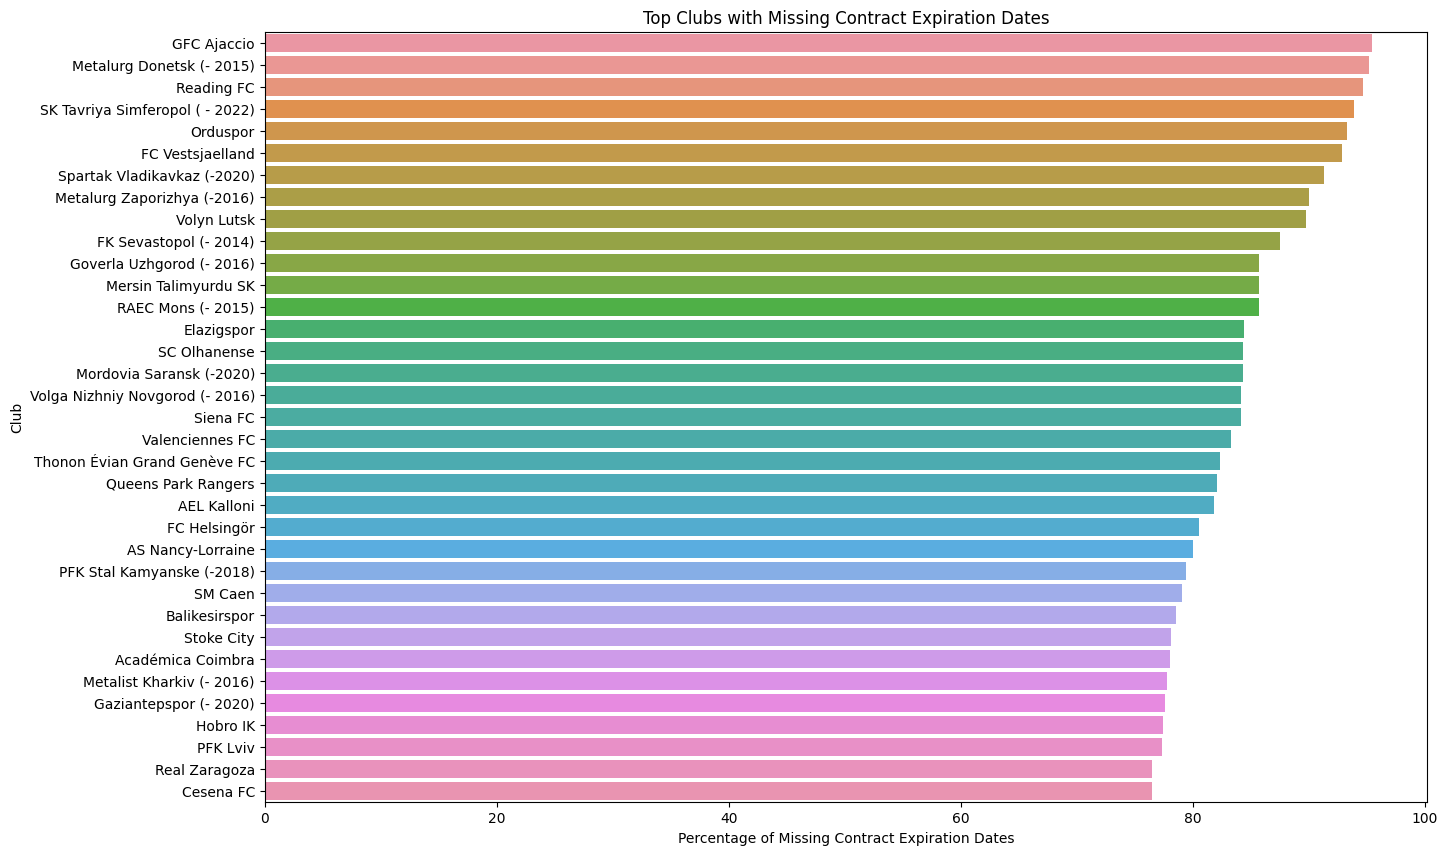

In [68]:
# Top clubs with missing 'contract_expiration_date'
top_clubs = percentage_missing_by_club.head(35)
plt.figure(figsize=(15, 10))
sns.barplot(x=top_clubs, y=top_clubs.index)
plt.title('Top Clubs with Missing Contract Expiration Dates')
plt.xlabel('Percentage of Missing Contract Expiration Dates')
plt.ylabel('Club')
plt.show()

### agent_name

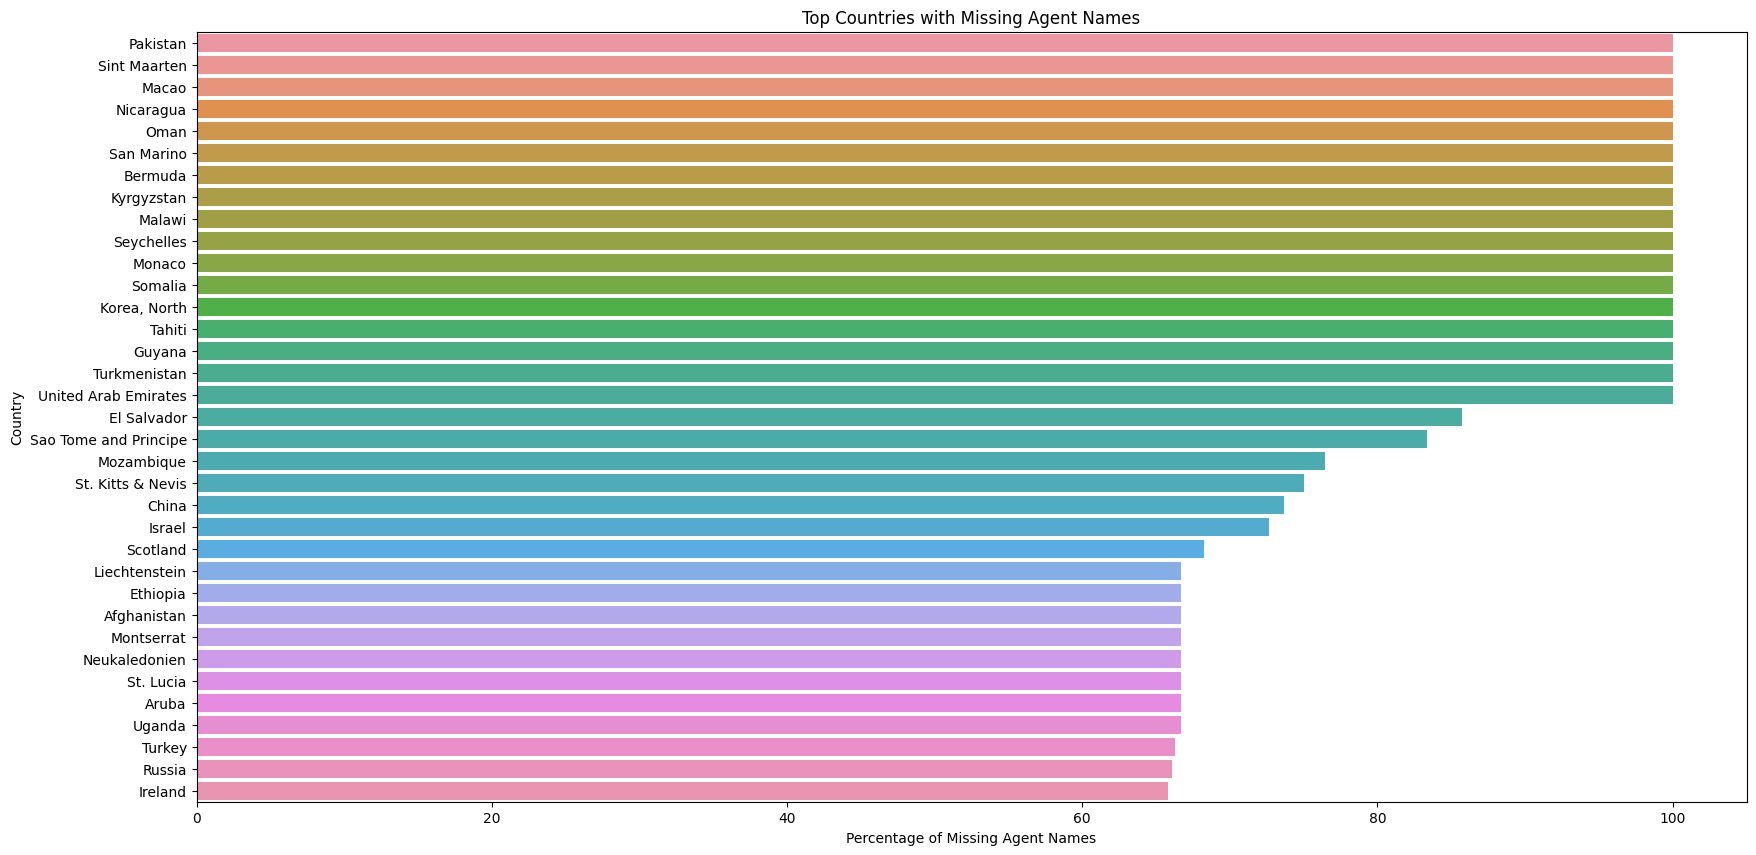

In [69]:
# Calculate the percentage of missing data by country
missing_by_country = players_df[players_df['agent_name'].isnull()].groupby('country_of_citizenship').size()
total_by_country = players_df.groupby('country_of_citizenship').size()
percentage_missing_by_country = (missing_by_country / total_by_country * 100).sort_values(ascending=False)

# Calculate the percentage of missing data by club
missing_by_club = players_df[players_df['agent_name'].isnull()].groupby('current_club_name').size()
total_by_club = players_df.groupby('current_club_name').size()
percentage_missing_by_club = (missing_by_club / total_by_club * 100).sort_values(ascending=False)

# Top countries with missing 'agent_name'
top_countries = percentage_missing_by_country.head(35)
plt.figure(figsize=(20, 10))
sns.barplot(x=top_countries, y=top_countries.index)
plt.title('Top Countries with Missing Agent Names')
plt.xlabel('Percentage of Missing Agent Names')
plt.ylabel('Country')
plt.show()

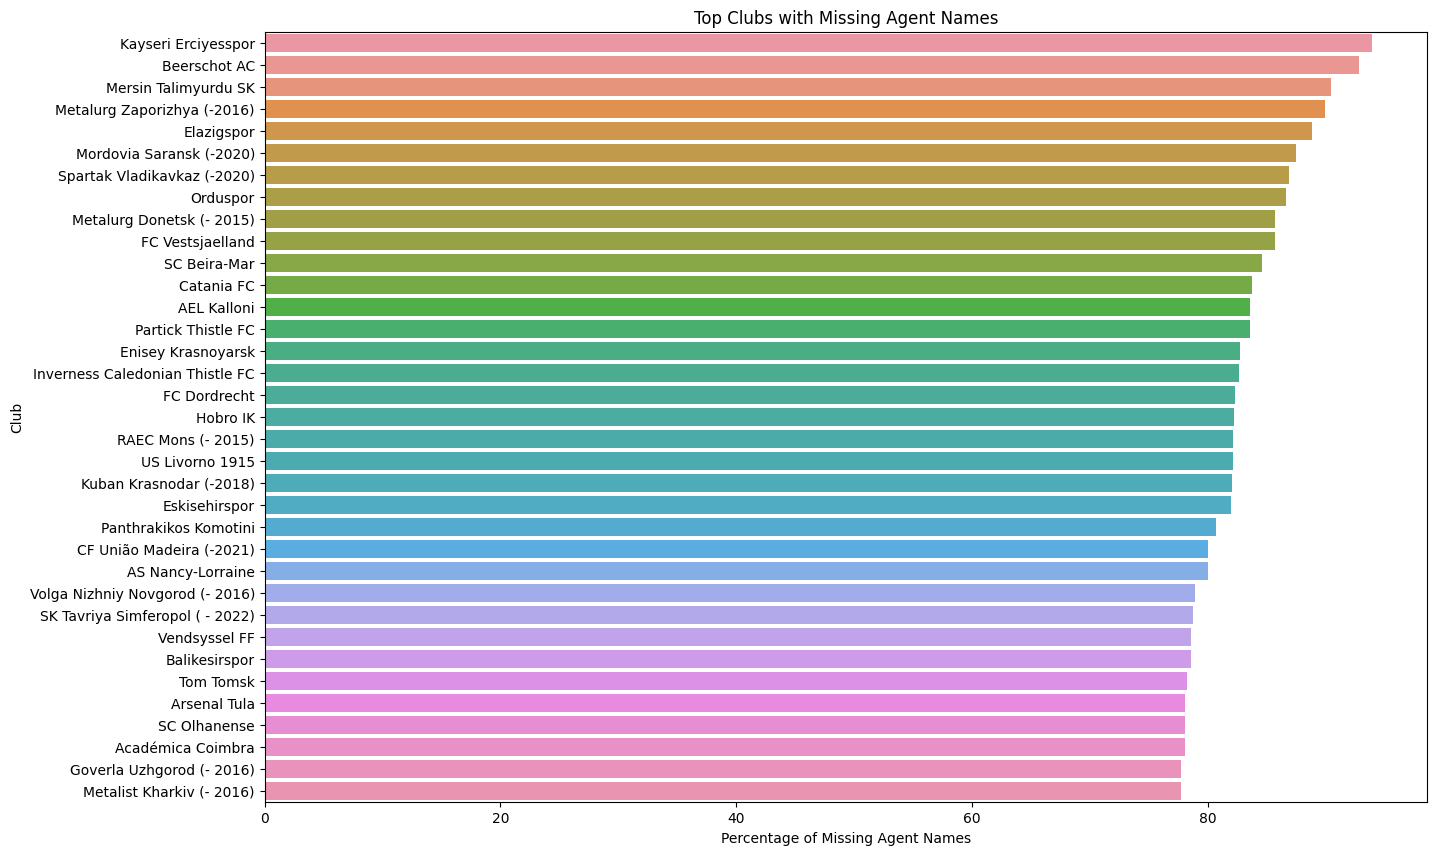

In [70]:
# Top clubs with missing 'agent_name'
top_clubs = percentage_missing_by_club.head(35)
plt.figure(figsize=(15, 10))
sns.barplot(x=top_clubs, y=top_clubs.index)
plt.title('Top Clubs with Missing Agent Names')
plt.xlabel('Percentage of Missing Agent Names')
plt.ylabel('Club')
plt.show()

# Reasonable Assumptions
Based on the plotted graphs, a few observations can be made:
## Top Clubs with Missing Market Values
- **Higher Missing Values in Lesser-Known Clubs**: The clubs at the top of the chart, with the highest percentage of missing data, seem to be lesser-known or potentially lower-division clubs. This could indicate that market values are less frequently assessed or reported for these clubs.

- **Possible Data Collection Gaps**: The presence of clubs with parentheses and years (e.g., "- 2016") may suggest these are defunct clubs or have undergone significant changes, possibly affecting the availability of up-to-date market value data.

## Top Countries with Missing Market Values
- **Smaller or Less Prominent Football Nations**: Many of the countries listed, such as North Korea, Tahiti, and Monaco, have less prominent football scenes. This most likely contributes to the lack of available market value data for players from these nations.

- **Data Availability Correlation**: The chart may reflect a correlation between the prominence of the country in the international football landscape and the availability of market data. More established footballing countries likely have more comprehensive data collection practices in place.

These visualizations suggest a potential bias in data collection toward players from more prominent football clubs and countries. For a more accurate analysis, it might be necessary to consider these biases and potentially adjust for them or focus on subsets of data where information is more complete.

In addition, the presence of clubs that no longer exist or have undergone significant changes raises questions about the temporal relevance of the data. It would be important to consider the time frame of the data collection and how it relates to current football market dynamics.


## Top Countries and Clubs with Missing Height Information
The first two charts focus on the missing `height_in_cm` data. We see a diverse range of countries, including Malawi and Kyrgyzstan, at the top. Similarly, clubs like Hvidovre IF and Orduspor are leading with missing height information. The presence of smaller or less internationally prominent countries and clubs could indicate that such data is less frequently recorded or reported for players from these areas.

## Top Countries and Clubs with Missing Contract Expiration Dates
The next two charts illustrate the missing `contract_expiration_date` data. It’s noticeable that countries like Laos and Oman and clubs like GFC Ajaccio and Metalurg Donetsk feature prominently. This suggests potential challenges in obtaining contract details from certain regions or perhaps a lesser focus on maintaining up-to-date contractual information for players in less prominent footballing nations and clubs.

## Top Countries and Clubs with Missing Agent Information
The final two charts depict missing `agent_name` data. Countries such as Pakistan and Sint Maarten, along with clubs like Kayseri Erciyesspor and Beerschot AC, are at the forefront. This missing data could be due to a variety of factors, including the possibility that players in these regions are less likely to have formal representation or that such information is not as readily available or deemed as important in certain footballing communities.



## Insights
The patterns suggest that missing data is not randomly distributed but is instead associated with certain countries and clubs, potentially reflecting the resources, data collection practices, and the overall prominence of football in these regions. Clubs that have years in parentheses may indicate that the data pertains to a period when these clubs were active, which could affect the availability and relevance of data.

For example, missing height data might not be as critical for certain analyses as missing contract or agent information, which could have more direct implications for understanding a player's market situation or professional relationships.





In [71]:
# Now that the pattern recongnition phase is completed, let's now substitue missing agent names with 'Unknown'
players_df['agent_name'] = players_df['agent_name'].fillna('unknown')

# 4. Exploratory Analysis and Visualization
Now that we've addressed data cleaning and understood the patterns of missing data, we can dive into the next phase which allows us to uncover underlying structures, extract important variables, detect outliers and anomalies, and test underlying assumptions.

## Descriptive Statistics
### Summary Statistics for Numeric Columns 

In [ ]:
# numerical columns like age, height, market value, etc

### Distribution of Categorical Data

In [ ]:
# distribution of players across different categories such as position, country, club, and foot preference.

## Visualization
### Age Distribution of Players

In [ ]:
#placeholder

### Height Distribution of Players

In [ ]:
# placeholder

### Market Value Distribution

In [ ]:
# placeholder

### Position Distribution

In [ ]:
# placeholder

### Club Representation

In [ ]:
# placeholder

### Country Representation

In [ ]:
# placeholder

# In-Depth Analysis 

### Market Value vs. Age

Market Value vs. Age: A scatter plot or line plot to see how market value correlates with age.

Height vs. Position: Box plots to compare the heights of players across different positions.

Club vs. Market Value: Aggregate the market values at the club level to identify the clubs with the highest cumulative market values.